In [1]:
import numpy as np
import pandas as pd # for dataframe and CSV handling
import argparse

from sklearn.model_selection import KFold
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.metrics import matthews_corrcoef, roc_auc_score, r2_score, mean_squared_error
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

try:
    import rdkit.Chem.Descriptors as Descriptors
    import rdkit.Chem as Chem
    has_rdkit = True
except:
    has_rdkit = False

from cliques.cliques import get_clique_decomposition

import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
import seaborn as sns

In [2]:
plt.rcParams.update({'font.size': 24})
cmap_discrete = sns.color_palette('colorblind', 10)
cmap_continuous = sns.dark_palette("#69d", reverse=True, as_cmap=True)

In [3]:
data = pd.read_csv('B3DB/B3DB_regression_clean.csv')

smiles = data.SMILES

y = data.logBB.to_numpy().astype(np.float32)

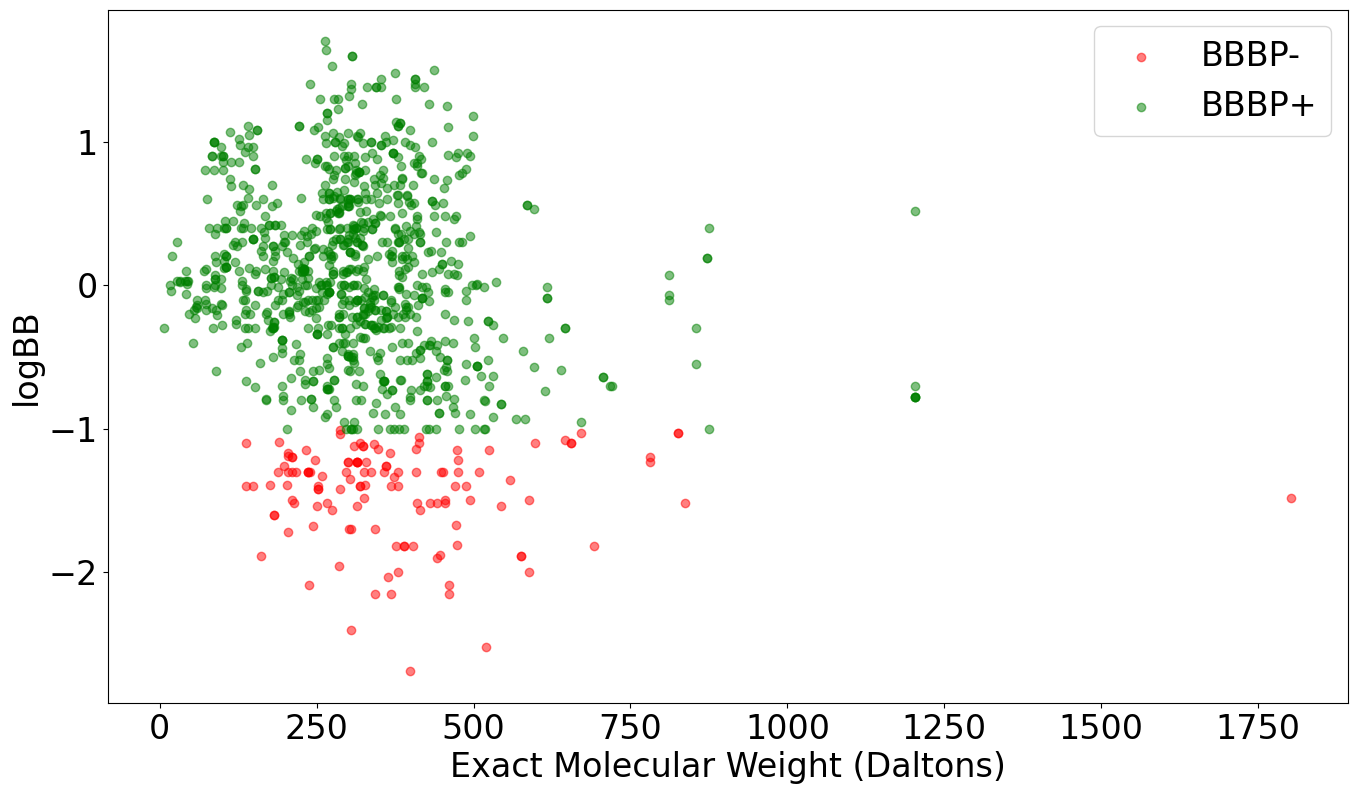

In [4]:
if has_rdkit:
    molwt = np.zeros(len(data))
    for i, smile in enumerate(smiles):
        molwt[i] = Chem.Descriptors.MolWt(Chem.MolFromSmiles(smile))

    np.save('molwt_regression.npy', molwt)
else:
    molwt = np.load('molwt_regression.npy')

plt.figure(figsize=(16, 9))
plt.scatter(molwt[y<-1], y[y<-1], alpha=0.5, color='red', label='BBBP-')
plt.scatter(molwt[y>=-1], y[y>=-1], alpha=0.5, color='green', label='BBBP+')
plt.ylabel('logBB')
plt.xlabel('Exact Molecular Weight (Daltons)')
plt.legend()

In [5]:
if has_rdkit:
    print('Computing clique decomposition')

    cliques, vocab = get_clique_decomposition(smiles)
    X = cliques.to_numpy().astype(int)

    X_present = (X > 0).astype(np.float32)
    X_counts = X_present.sum(axis=0)
    top_counts = np.argsort(X_counts)[-20:]

    vocab_selected = np.array(vocab)[top_counts]
    X_counts = X_counts[top_counts]
    X_present = X_present[:, top_counts]

    print('Most common clique')
    print(vocab_selected[0], 'occurs', X_counts[-1], 'times')
    print('20th most common clique')
    print(vocab_selected[-1], 'occurs', X_counts[0], 'times')

    np.save('vocab_selected_regression.npy', vocab_selected)
    np.save('X_counts_regression.npy', X_counts)
else:
    vocab_selected = np.load('vocab_selected_regression.npy')
    X_counts = np.load('X_counts_regression.npy')

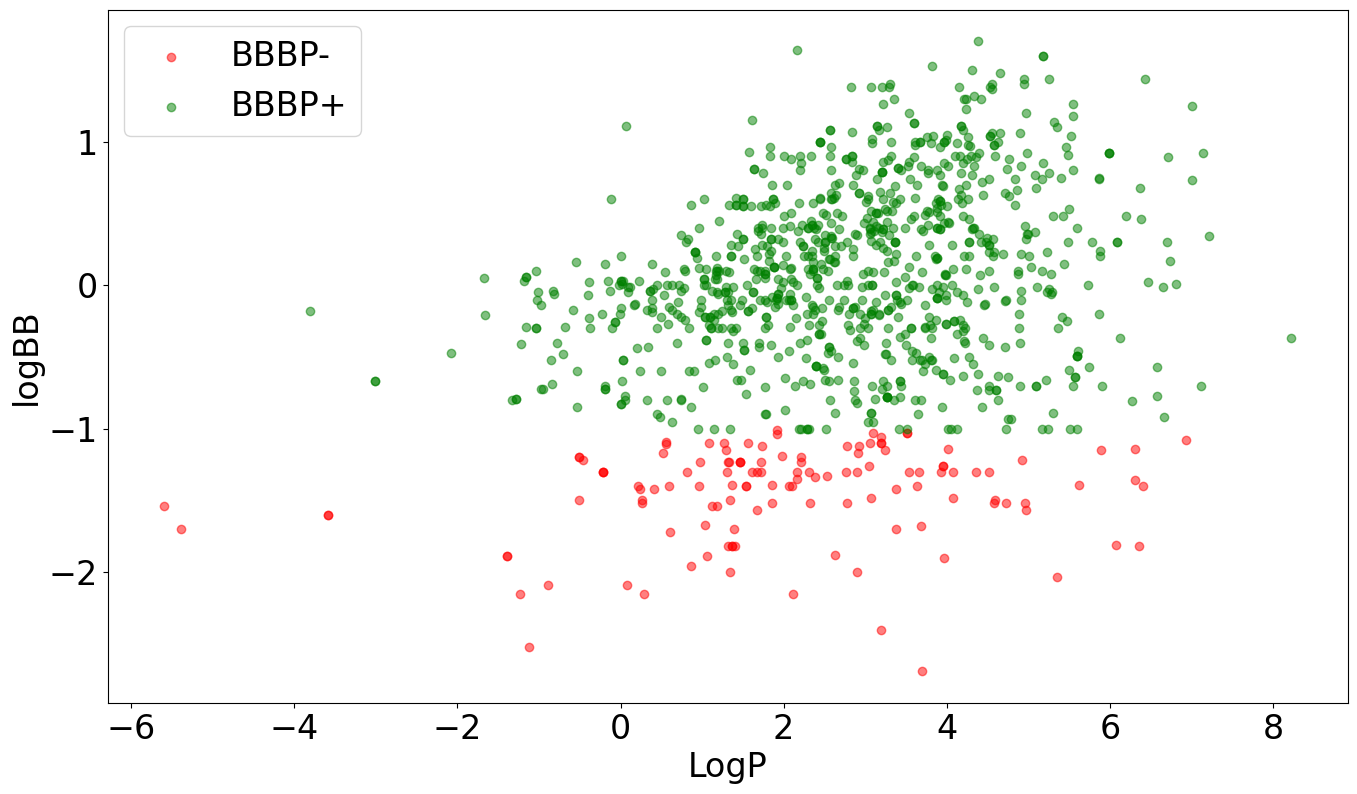

In [6]:
if has_rdkit:
    logP = np.zeros(len(data))
    for i, smile in enumerate(smiles):
        logP[i] = Chem.Descriptors.MolLogP(Chem.MolFromSmiles(smile))

    np.save('logP_regression.npy', logP)
else:
    logP = np.load('logP_regression.npy')

plt.figure(figsize=(16, 9))
plt.scatter(logP[y<-1], y[y<-1], alpha=0.5, color='red', label='BBBP-')
plt.scatter(logP[y>=-1], y[y>=-1], alpha=0.5, color='green', label='BBBP+')
plt.ylabel('logBB')
plt.xlabel('LogP')
plt.legend()